

---
---

* Install Needed Libraries :

---
---



In [3]:
!pip install pandas scikit-learn fairlearn shap matplotlib seaborn --quiet
!pip install pandas scikit-learn fairlearn shap matplotlib seaborn wordcloud --quiet



---
---
* Importing Needed Libraries :
---
---



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from wordcloud import WordCloud
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from fairlearn.metrics import (demographic_parity_difference,equalized_odds_difference,selection_rate)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity



---
---
* Loading and prepareing data for training :
---
---



In [5]:
data = pd.read_csv("/content/data.csv")
education_map = {1: "HighSchool", 2: "Bachelor", 3: "Master", 4: "PhD"}
strategy_map = {1: "Campus", 2: "JobBoard", 3: "Referral"}
gender_map = {0: "Female", 1: "Male"}
data["text"] = data.apply(
    lambda x: f"Age {x['Age']}, Gender {gender_map[x['Gender']]}, "
    f"Education: {education_map[x['EducationLevel']]}, "
    f"Experience: {x['ExperienceYears']} years, "
    f"Distance: {x['DistanceFromCompany']} miles, "
    f"Interview: {x['InterviewScore']}, "
    f"Skill: {x['SkillScore']}, "
    f"Personality: {x['PersonalityScore']}, "
    f"Recruitment: {strategy_map[x['RecruitmentStrategy']]}",
    axis=1,
)



---
---
* Exploratory data analysis :
---
---



In [8]:
print("\n=== BASIC DATASET INFO ===")
print(f"Total records: {len(data)}")
print(f"Features: {list(data.columns)}")


=== BASIC DATASET INFO ===
Total records: 1500
Features: ['Age', 'Gender', 'EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy', 'HiringDecision', 'text']


Text(0.5, 1.0, 'Age Distribution')

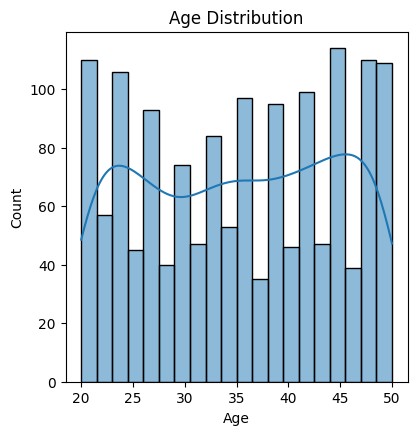

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.histplot(data['Age'], bins=20, kde=True)
plt.title('Age Distribution')

Text(0.5, 1.0, 'Education Level Distribution')

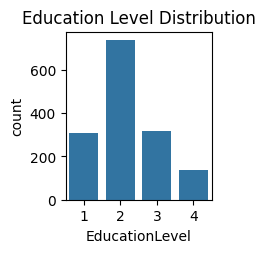

In [10]:
plt.subplot(2, 3, 2)
sns.countplot(x='EducationLevel', data=data)
plt.title('Education Level Distribution')

Text(0.5, 1.0, 'Experience Years Distribution')

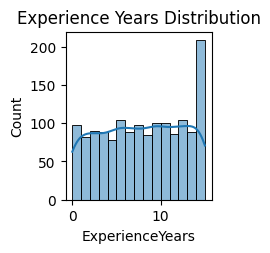

In [11]:
plt.subplot(2, 3, 3)
sns.histplot(data['ExperienceYears'], bins=15, kde=True)
plt.title('Experience Years Distribution')

Text(0.5, 1.0, 'Gender Distribution')

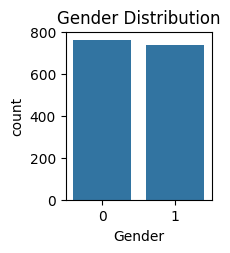

In [12]:
plt.subplot(2, 3, 4)
sns.countplot(x='Gender', data=data)
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Recruitment Strategy')

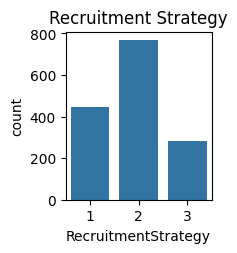

In [13]:
plt.subplot(2, 3, 5)
sns.countplot(x='RecruitmentStrategy', data=data)
plt.title('Recruitment Strategy')

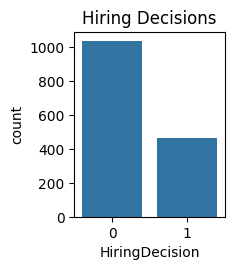

In [14]:
plt.subplot(2, 3, 6)
sns.countplot(x='HiringDecision', data=data)
plt.title('Hiring Decisions')
plt.tight_layout()
plt.show()

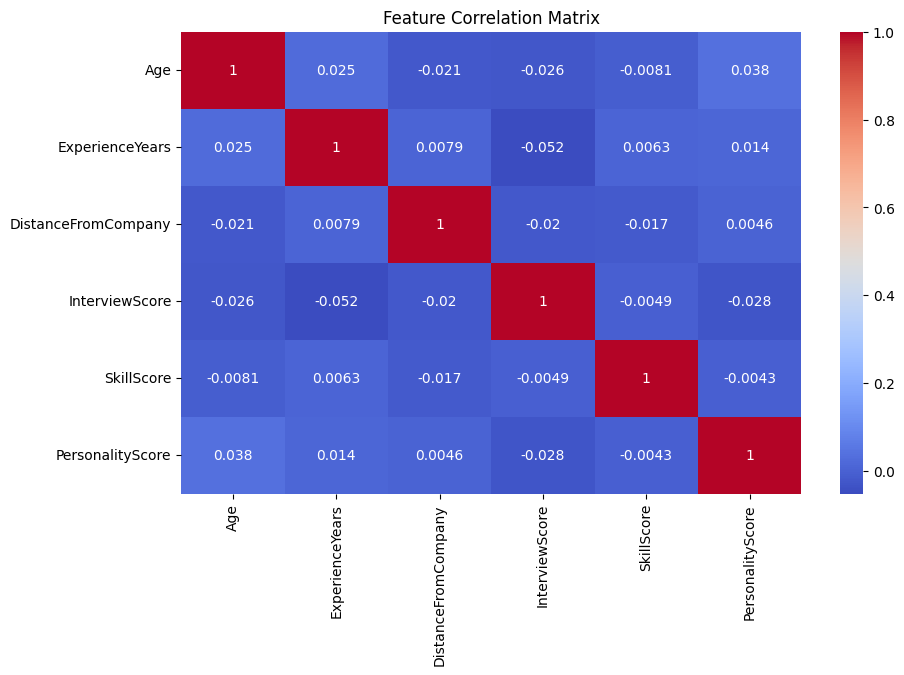

In [15]:
# Correlation analysis
numeric_cols = ['Age', 'ExperienceYears', 'DistanceFromCompany','InterviewScore', 'SkillScore', 'PersonalityScore']
plt.figure(figsize=(10, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


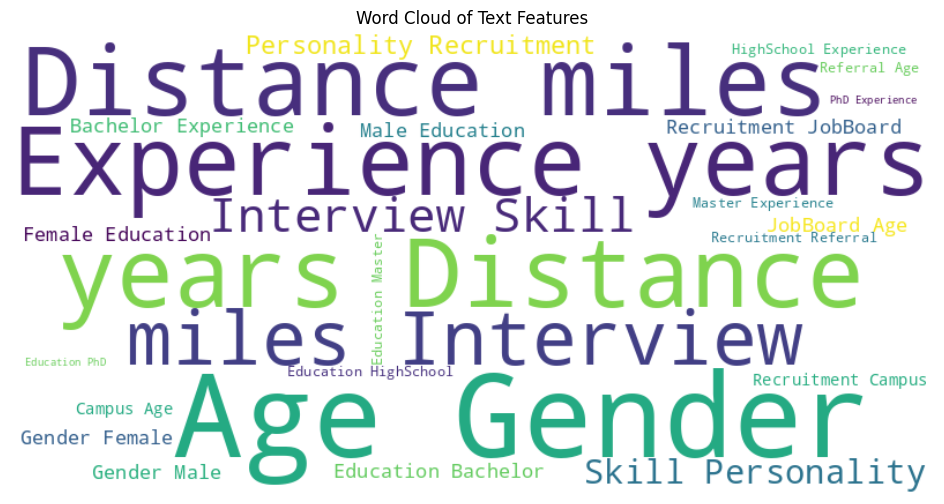

In [16]:
# Word cloud for text features
text = " ".join(data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Text Features')
plt.show()

---
---
* Splitting data and preperaing it for training :
---
---

In [17]:
# Create imbalanced train-test split (80% male in train, 50% in test)
male_data = data[data["Gender"] == 1]
female_data = data[data["Gender"] == 0]
male_train, male_test = train_test_split(male_data, train_size=0.8, random_state=42)
female_train, female_test = train_test_split(female_data, train_size=0.8, random_state=42)
required_female = int((len(male_train) / 0.8) - len(male_train))
train_data = pd.concat([male_train, female_train.sample(required_female, random_state=42)])
test_data = pd.concat([male_test, female_test])

---
---
* training model over data :
---
---

In [18]:
# Initialize vectorizer separately for mitigation
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X_train = vectorizer.fit_transform(train_data["text"])
X_test = vectorizer.transform(test_data["text"])
# Train initial model
model = LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
model.fit(X_train, train_data["HiringDecision"])

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)



---
---
* Evaluating model over test data :
---
---



In [19]:
test_preds = model.predict(X_test)
print("=== Model Performance ===")
print(classification_report(test_data["HiringDecision"], test_preds))

=== Model Performance ===
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       206
           1       0.70      0.73      0.72        95

    accuracy                           0.82       301
   macro avg       0.79      0.79      0.79       301
weighted avg       0.82      0.82      0.82       301





---
---

* Bias Detection :

---
---



In [21]:
print("\n=== Bias Metrics ===")
demo_parity = demographic_parity_difference(test_data["HiringDecision"], test_preds, sensitive_features=test_data["Gender"])
eq_opp = equalized_odds_difference( test_data["HiringDecision"], test_preds, sensitive_features=test_data["Gender"])
male_rate = selection_rate(test_data["HiringDecision"][test_data["Gender"] == 1], test_preds[test_data["Gender"] == 1])
female_rate = selection_rate(test_data["HiringDecision"][test_data["Gender"] == 0],test_preds[test_data["Gender"] == 0])
print(f"Demographic Parity Difference: {demo_parity:.3f}")
print(f"Equal Opportunity Difference: {eq_opp:.3f}")
print(f"Male Hire Rate: {male_rate:.2%}, Female Hire Rate: {female_rate:.2%}")



=== Bias Metrics ===
Demographic Parity Difference: 0.091
Equal Opportunity Difference: 0.085
Male Hire Rate: 37.16%, Female Hire Rate: 28.10%




---
---
* Hiring rate by Gender :
---
---



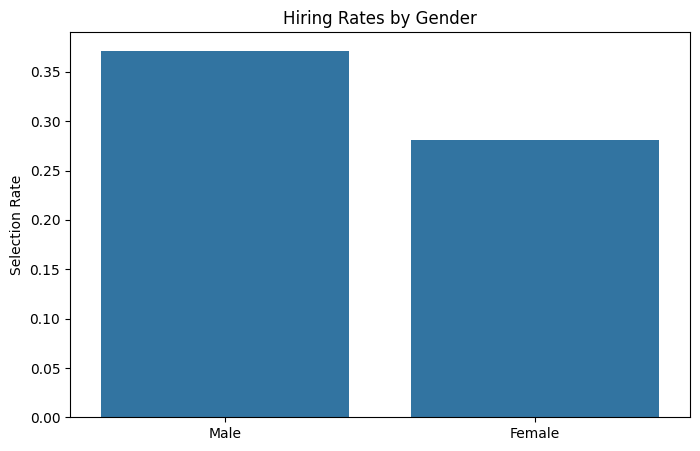

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=["Male", "Female"], y=[male_rate, female_rate])
plt.title("Hiring Rates by Gender")
plt.ylabel("Selection Rate")
plt.show()



---
---
* Explainability & Bias Attribution :
---
---







=== SHAP Explanations for 5 Cases (3 Hire, 2 No-Hire) ===

=== Case 1 (Index: 155) ===
Prediction: Hire
Actual: Hire
Gender: Female

Text Preview:
Age 49.0, Gender Female, Education: Bachelor, Experience: 7.0 years, Distance: 25.46136273749596 miles, Interview: 41.0, Skill: 89.0, Personality: 16.0, Recruitment: Campus...


Top 5 Influential Words:
campus: 0.9961
89: 0.4548
25: -0.2538
bachelor: -0.2175
41: -0.1420


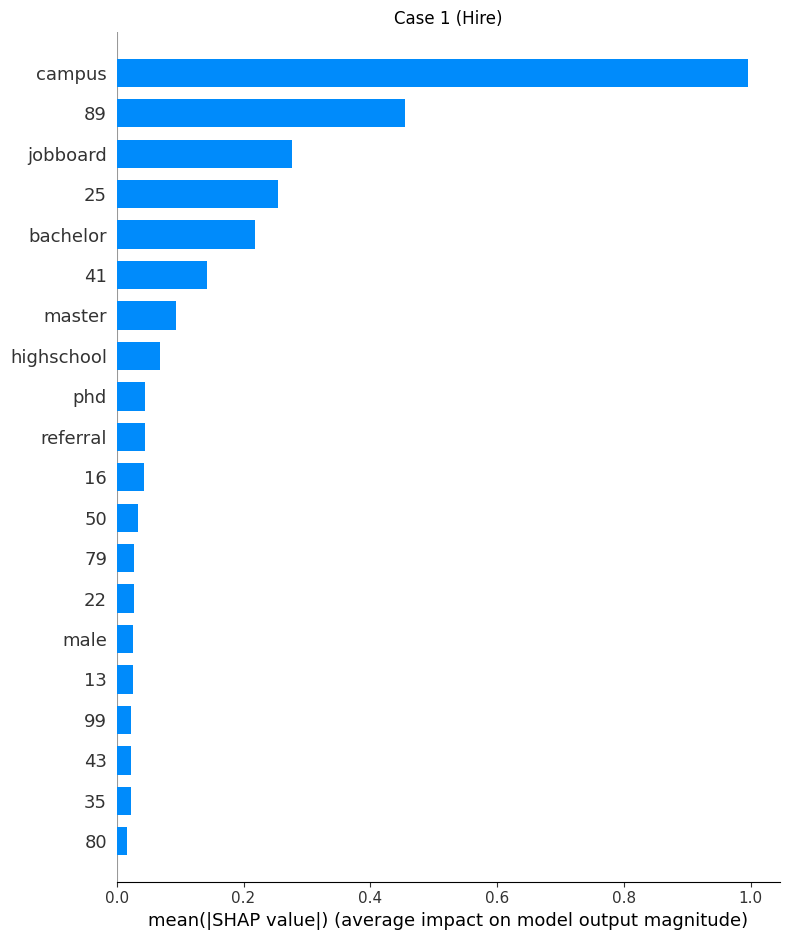


=== Case 2 (Index: 210) ===
Prediction: Hire
Actual: Hire
Gender: Female

Text Preview:
Age 33.0, Gender Female, Education: HighSchool, Experience: 13.0 years, Distance: 32.72782338707624 miles, Interview: 73.0, Skill: 83.0, Personality: 35.0, Recruitment: Campus...


Top 5 Influential Words:
campus: 0.8240
83: 0.4560
35: -0.2487
highschool: -0.2459
13: -0.1624


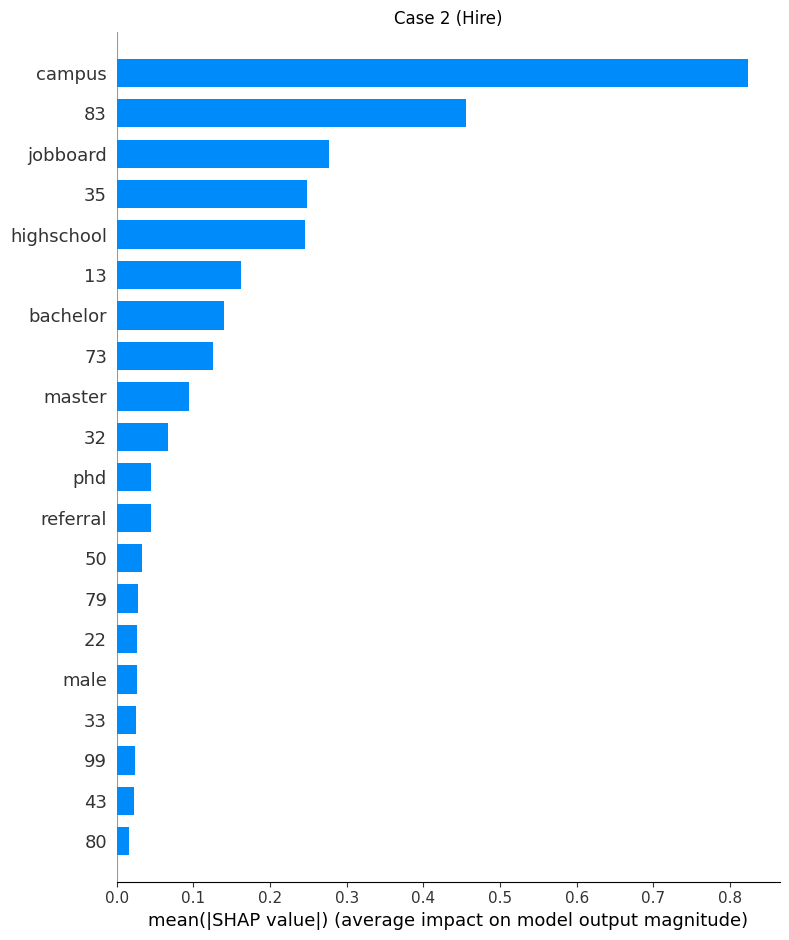


=== Case 3 (Index: 175) ===
Prediction: Hire
Actual: No Hire
Gender: Female

Text Preview:
Age 33.0, Gender Female, Education: Master, Experience: 12.0 years, Distance: 35.18941004449373 miles, Interview: 64.0, Skill: 91.0, Personality: 21.0, Recruitment: JobBoard...


Top 5 Influential Words:
master: 0.4376
91: 0.4013
jobboard: -0.2771
35: -0.2566
64: 0.1044


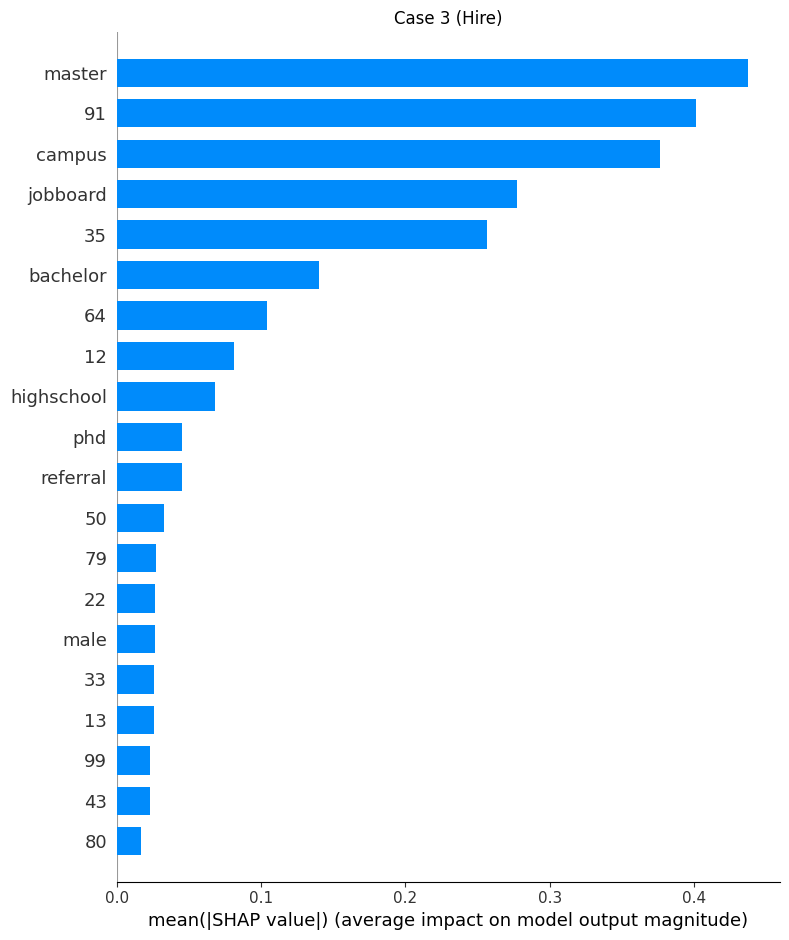


=== Case 4 (Index: 115) ===
Prediction: No Hire
Actual: Hire
Gender: Male

Text Preview:
Age 32.0, Gender Male, Education: HighSchool, Experience: 15.0 years, Distance: 36.104128344224826 miles, Interview: 100.0, Skill: 76.0, Personality: 97.0, Recruitment: JobBoard...


Top 5 Influential Words:
100: 0.3986
jobboard: -0.2791
highschool: -0.2563
36: -0.1423
76: 0.1168


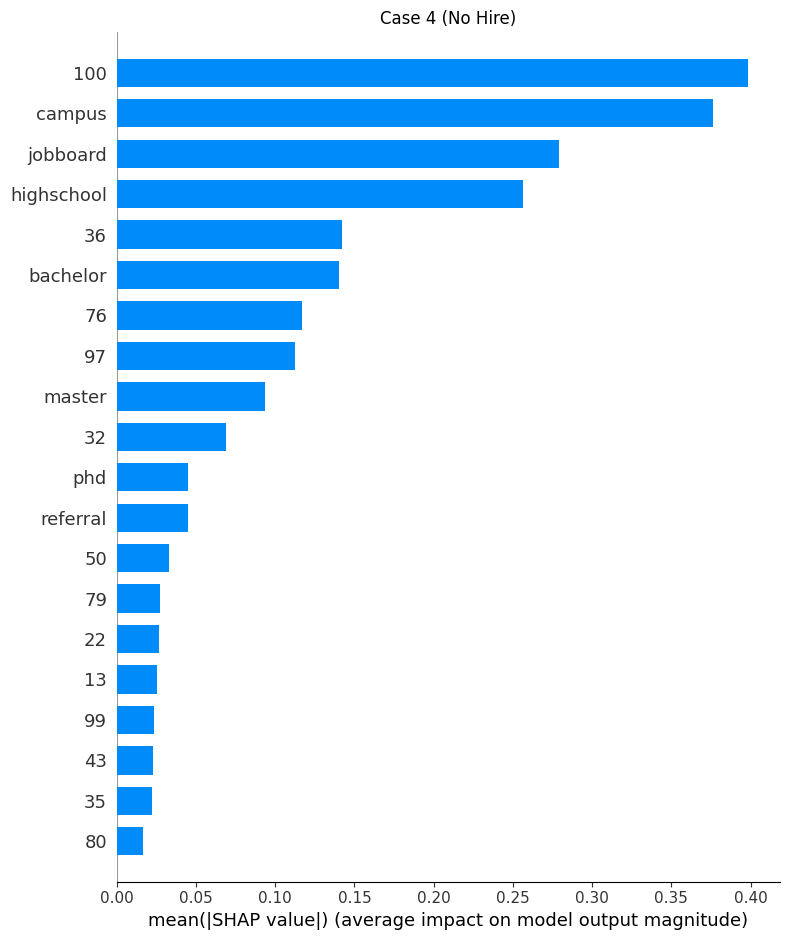


=== Case 5 (Index: 225) ===
Prediction: No Hire
Actual: Hire
Gender: Female

Text Preview:
Age 38.0, Gender Female, Education: PhD, Experience: 9.0 years, Distance: 19.080365921269475 miles, Interview: 85.0, Skill: 81.0, Personality: 2.0, Recruitment: JobBoard...


Top 5 Influential Words:
phd: 0.6213
jobboard: -0.3057
85: 0.2389
19: -0.1456
81: 0.1003


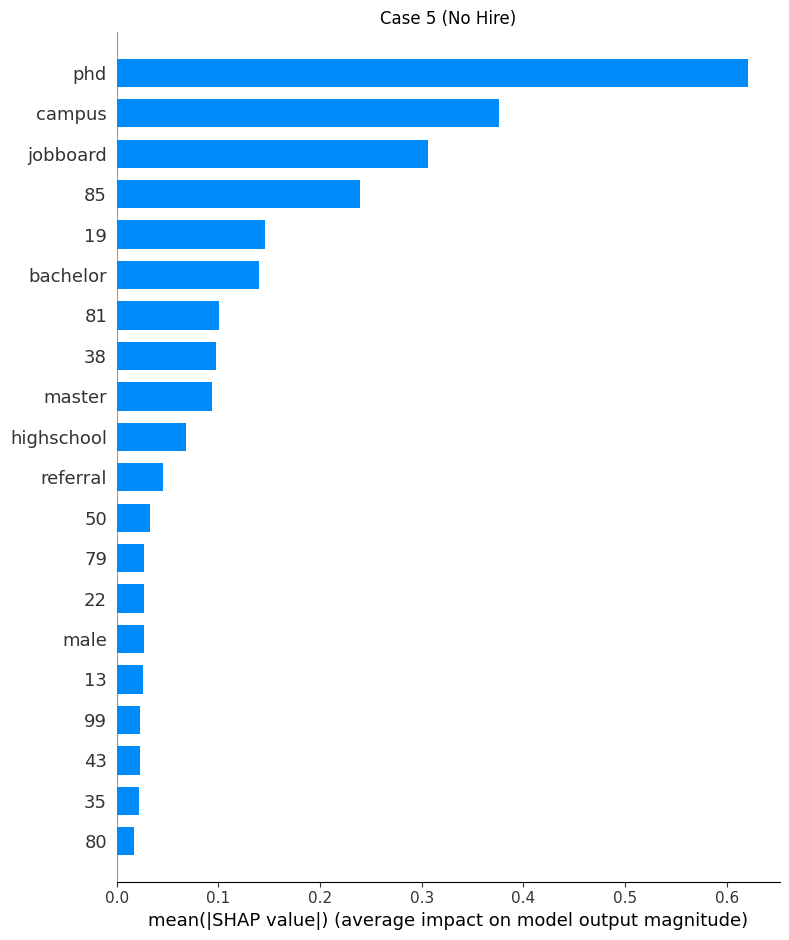


=== Gender Bias Analysis ===

Gender-Correlated Terms Influencing Decisions:

No significant male-correlated terms found.

No significant female-correlated terms found.

No significant name_patterns-correlated terms found.

=== Bias Mitigation Recommendations ===
No significant gender bias detected in word-level analysis.
For continued fairness monitoring:
1. Track fairness metrics over time
2. Implement ongoing bias audits
3. Consider testing with synthetic edge cases


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

def explain_model_predictions(model, X_train, test_data, test_preds, vectorizer, gender_map):
    """
    Explain model predictions using SHAP and analyze gender bias

    Args:
        model: Trained classifier
        X_train: Training data features
        test_data: Test dataset DataFrame with 'text', 'Gender', 'HiringDecision'
        test_preds: Model predictions on test data
        vectorizer: Fitted text vectorizer
        gender_map: Dictionary mapping gender codes to labels
    """

    print("\n=== SHAP Explanations for 5 Cases (3 Hire, 2 No-Hire) ===")

    # Initialize SHAP explainer
    explainer = shap.LinearExplainer(
        model,
        X_train,
        feature_names=vectorizer.get_feature_names_out(),
    )

    # Reset index to ensure proper referencing
    test_data = test_data.reset_index(drop=True)
    test_preds = np.array(test_preds)  # Ensure test_preds is numpy array

    # Select sample cases (3 Hire, 2 No-Hire)
    hire_indices = np.where(test_preds == 1)[0]
    no_hire_indices = np.where(test_preds == 0)[0]

    selected_indices = np.concatenate([
        np.random.choice(hire_indices, 3, replace=False),
        np.random.choice(no_hire_indices, 2, replace=False)
    ])

    # Gender-correlated terms to watch for
    gender_terms = {
        'male': ['he', 'him', 'his', 'man', 'men', 'mr', 'mister'],
        'female': ['she', 'her', 'hers', 'woman', 'women', 'ms', 'miss', 'mrs'],
        'name_patterns': ['john', 'mike', 'david', 'mary', 'sarah', 'emily']
    }

    # Analyze individual cases
    gender_bias_words = {gender: [] for gender in gender_terms.keys()}

    for i, idx in enumerate(selected_indices):
        row = test_data.loc[idx]
        print(f"\n=== Case {i+1} (Index: {idx}) ===")
        print(f"Prediction: {'Hire' if test_preds[idx] == 1 else 'No Hire'}")
        print(f"Actual: {'Hire' if row['HiringDecision'] == 1 else 'No Hire'}")
        print(f"Gender: {gender_map[row['Gender']]}")
        print(f"\nText Preview:\n{row['text'][:200]}...\n")

        # Get SHAP values
        text_transformed = vectorizer.transform([row["text"]]).toarray()
        shap_values = explainer.shap_values(text_transformed)

        # Get feature names and their importance
        feature_names = vectorizer.get_feature_names_out()
        word_importance = {
            feature_names[i]: shap_values[0][i]
            for i in range(len(feature_names))
            if text_transformed[0][i] != 0
        }

        # Print top influential words
        print("\nTop 5 Influential Words:")
        top_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:5]

        for word, importance in top_words:
            print(f"{word}: {importance:.4f}", end="")

            # Check for gender-correlated terms
            for gender, terms in gender_terms.items():
                if word.lower() in terms:
                    print(f" [Potential {gender} bias]", end="")
                    gender_bias_words[gender].append((word, importance, test_preds[idx]))
            print()

        # Plot SHAP values
        plt.figure(figsize=(10, 4))
        shap.summary_plot(shap_values, text_transformed,
                         feature_names=feature_names,
                         plot_type="bar", show=False)
        plt.title(f"Case {i+1} ({'Hire' if test_preds[idx] == 1 else 'No Hire'})")
        plt.tight_layout()
        plt.show()

    # Analyze overall gender bias patterns
    print("\n=== Gender Bias Analysis ===")
    print("\nGender-Correlated Terms Influencing Decisions:")

    for gender, words in gender_bias_words.items():
        if words:
            print(f"\n{gender.capitalize()}-correlated terms found:")
            unique_words = {}
            for word, value, pred in words:
                if word not in unique_words:
                    unique_words[word] = []
                unique_words[word].append(value)

            for word in sorted(unique_words.keys()):
                avg_impact = np.mean(unique_words[word])
                print(f"{word}: Avg impact {avg_impact:.4f} (Appeared {len(unique_words[word])} times)")
        else:
            print(f"\nNo significant {gender}-correlated terms found.")

    print("\n=== Bias Mitigation Recommendations ===")
    if any(len(words) > 0 for words in gender_bias_words.values()):
        print("WARNING: Potential gender bias detected. Recommended actions:")
        print("1. Remove explicit gender indicators during text preprocessing")
        print("2. Apply bias mitigation techniques like:")
        print("   - Reweighing (adjust sample weights)")
        print("   - Adversarial debiasing")
        print("   - Counterfactual data augmentation")
        print("3. Review training data for representation balance")
        print("4. Consider using gender-neutral feature engineering")
    else:
        print("No significant gender bias detected in word-level analysis.")
        print("For continued fairness monitoring:")
        print("1. Track fairness metrics over time")
        print("2. Implement ongoing bias audits")
        print("3. Consider testing with synthetic edge cases")

# Example usage:
explain_model_predictions(model, X_train, test_data, test_preds, vectorizer, gender_map)



---
---
* Bias Mitigation :
---
---



In [22]:
print("\n=== Bias Mitigation (Reweighing) ===")
mitigator = ExponentiatedGradient(estimator=LogisticRegression(max_iter=1000, random_state=42),constraints=DemographicParity(),)
mitigator.fit(
    X_train.toarray(),  # Convert sparse to dense
    train_data["HiringDecision"],
    sensitive_features=train_data["Gender"],
)
mitigated_preds = mitigator.predict(X_test.toarray())

print("\nPerformance After Mitigation:")
print(classification_report(test_data["HiringDecision"], mitigated_preds))

print("\nFairness After Mitigation:")
new_demo_parity = demographic_parity_difference(
    test_data["HiringDecision"], mitigated_preds, sensitive_features=test_data["Gender"]
)
new_eq_opp = equalized_odds_difference(
    test_data["HiringDecision"], mitigated_preds, sensitive_features=test_data["Gender"]
)
print(f"New Demographic Parity: {new_demo_parity:.3f} (Before: {demo_parity:.3f})")
print(f"New Equal Opportunity: {new_eq_opp:.3f} (Before: {eq_opp:.3f})")


=== Bias Mitigation (Reweighing) ===

Performance After Mitigation:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       206
           1       0.80      0.55      0.65        95

    accuracy                           0.81       301
   macro avg       0.81      0.74      0.76       301
weighted avg       0.81      0.81      0.80       301


Fairness After Mitigation:
New Demographic Parity: 0.067 (Before: 0.091)
New Equal Opportunity: 0.088 (Before: 0.085)
